In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import fastai
import pydicom as dicom
from fast_dicom import *

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.set_device(1)

In [5]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS/")
fnames = list(PATH.glob('50mm/image/*'))

In [6]:
img_path = PATH / '50mm' / 'image'
mask_path = PATH / '50mm' / 'mask'

In [7]:
study_names = sorted(list(set([i.stem.split('_')[0] for i in img_path.ls() if 'models' not in i.name])))
n_study_names = len(study_names)
trn_names, val_names = study_names[0:int(n_study_names // 1.2)], study_names[int(n_study_names // 1.2):]
split_func = lambda x: x.stem.split('_')[0] in val_names

In [8]:
img_paths = get_image_files(img_path)
get_y_fn = lambda x: mask_path / x.name

In [9]:
tfms = get_transforms(do_flip=False)

In [10]:
codes = ['bg', 'Heart']

db = SegmentationItemList.from_folder(img_path)
db = db.filter_by_func(lambda x: x.stem.split('_')[0] in val_names or x.stem.split('_')[0] in trn_names)
db = db.split_by_valid_func(split_func)
db = db.label_from_func(get_y_fn, classes=codes)
db = db.transform(tfms, size=(256,256), tfm_y=True)
db = db.databunch(bs=16)
db = db.normalize(imagenet_stats)

In [11]:
db.valid_ds.classes

['bg', 'Heart']

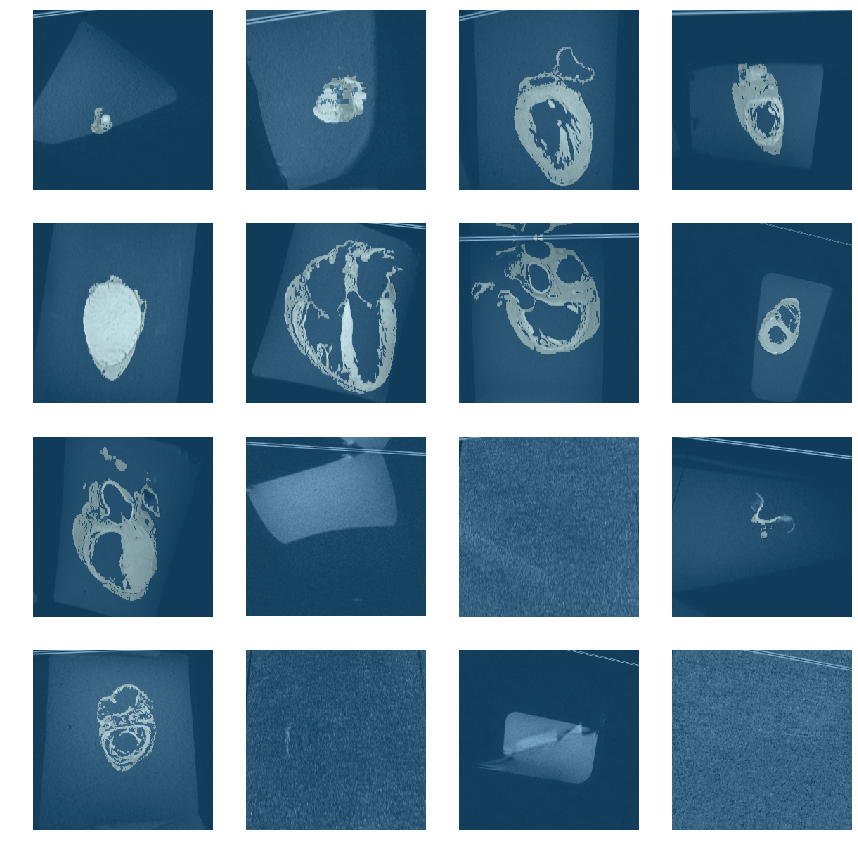

In [12]:
db.show_batch(4, figsize=(12,12))

In [13]:
len(db.train_ds), len(db.valid_ds)

(24122, 5720)

In [11]:
learn = unet_learner(db, models.resnet34, wd=1e-2)

In [15]:
lr_find(learn, end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


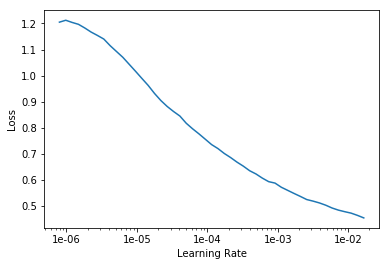

In [16]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,time
0,0.033537,0.026243,11:18
1,0.025007,0.021254,11:16
2,0.022681,0.022534,11:18
3,0.022997,0.021804,11:18


In [16]:
learn.save('4 epoch frozen')

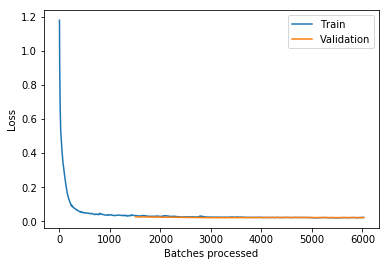

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(4, 1e-6)

epoch,train_loss,valid_loss,time
0,0.020926,0.021807,11:49
1,0.020954,0.021616,11:48
2,0.020914,0.021661,11:46
3,0.021400,0.021754,11:46


In [20]:
learn.save('4 epoch unfrozen')

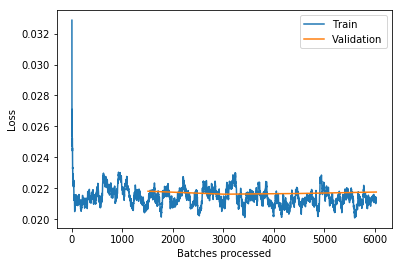

In [21]:
learn.recorder.plot_losses()

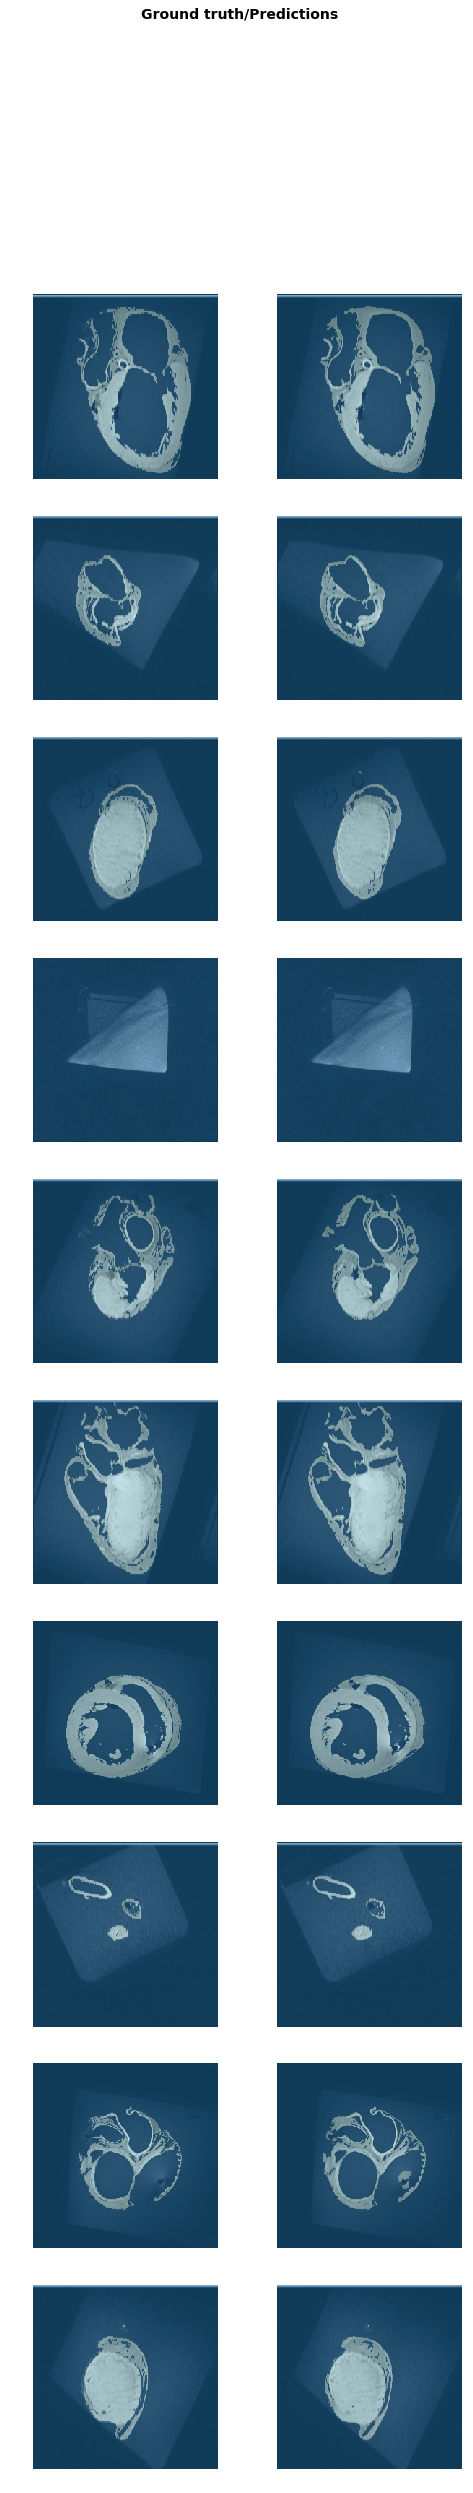

In [22]:
learn.show_results(rows=10)

In [12]:
#learn.load('4 epoch unfrozen');

In [85]:
class DicomEval():
    def __init__(self, learn, path):
        #Append miou callback for learn
        n_classes = learn.data.c
        self.learn = learn
        self.orig_data = learn.data
        
        self.path = path
        
        self.conf_mats = np.zeros((n_classes, n_classes))
        
    def one_study(self, study_name):
        res = []
        ys = None
        for ind, axis in enumerate(['0']):#, '1', '2']):
            data, orig_shape = dataset_val(self.path, study_name, axis, codes=["background", "Heart"])
            self.learn.data = data
            preds = self.learn.get_preds()
            xs = preds[0]
            xs = F.interpolate(xs, size=orig_shape)
            
            if ind == 1:
                xs = xs.permute(2, 1, 0, 3) #3,0
            elif ind == 2:
                xs = xs.permute(2,1,3,0)
            res.append(xs)
            if ys is None:
                ys = preds[1]
                ys = F.interpolate(ys.float(), size=orig_shape).long()
            
        self.learn.data = self.orig_data
        
        #Here we reshape the res tensors back.
        targ_shape = list(res[0].shape[1:])
        targ_shape.insert(0, res[1].shape[0])
        res = [resize_3d(i, size=tuple(targ_shape)) for i in res]
        targ_shape[1] = 1
        ys = resize_3d(ys, size=tuple(targ_shape))

 

        res = sum(res).argmax(1)

        #res = res[2].argmax(1)
        return res, ys[:,0]
    
def save_3d_model(save_folder, study_name, dc_eval, spacing=[1.,1.,1.], classes=['background', 'RA',  'RV', 'LA', 'LV']):
    res, y = dc_eval.one_study(study_name)
    #res = res.permute(2,1,0)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    save_names = [save_folder / f"{study_name}_{i}.stl" for i in classes]

    for ind, save_name in enumerate(save_names):
        if "background" in save_name.stem:
            continue
        verts, faces, normals, values = measure.marching_cubes_lewiner( (res == ind).float().numpy(), 0, step_size=1, spacing=spacing)

        # Display resulting triangular mesh using Matplotlib. This can also be done
        # with mayavi (see skimage.measure.marching_cubes_lewiner docstring).

        cube = stl_mesh.Mesh(np.zeros(faces.shape[0], dtype=stl_mesh.Mesh.dtype))
        for ind, f in enumerate(faces):
            for j in range(3):
                cube.vectors[ind][j] = verts[f[j],::-1]

        cube.save(str(save_name))
        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        mesh.set_facecolor('r')
        ax.add_collection3d(mesh)

    ax.set_xlim(0, 200)  # a = 6 (times two for 2nd ellipsoid)
    ax.set_ylim(0, 250)  # b = 10
    ax.set_zlim(0, 250)  # c = 16

    plt.tight_layout()
    plt.show()
    
def dataset_val(path, val_study, axis, codes):
    split_func = lambda x: x.stem.split('_')[0] == val_study and x.stem.split('_')[1] == str(axis)
    
    # TODO: pLEASE FIX
    get_y_fn = lambda x: path / 'mask' / x.name
    
    db = (SegmentationItemList.from_folder(path)
          .filter_by_func(lambda x: 'mask' not in str(x))
          .split_by_valid_func(split_func))
    #Let's keep these in a nicer stack, thanks
    db.valid.items = np.array(sorted(db.valid.items, key=lambda x: int(x.stem.split('_')[-1])))
    orig_shape = db.valid[0].shape[-2:]
    close_shape = [i / 2 for i in orig_shape] if 512 in orig_shape else orig_shape
    close_shape = [int(round(i / 32)*32) for i in close_shape]
    db = (db.label_from_func(get_y_fn, classes=codes)
          .transform(2*[squish()], size=close_shape, resize_method=ResizeMethod.SQUISH, tfm_y=True,)
          .databunch(bs=2,  no_check=True)
          .normalize(imagenet_stats))
    return db, orig_shape

In [86]:
dc_eval = DicomEval(learn, PATH / 'test')

In [83]:
val_names[1]

'HH0256'

In [87]:
res, y = dc_eval.one_study('hh256')

IndexError: list index out of range

In [71]:
np.shape(res)

torch.Size([336, 400, 400])

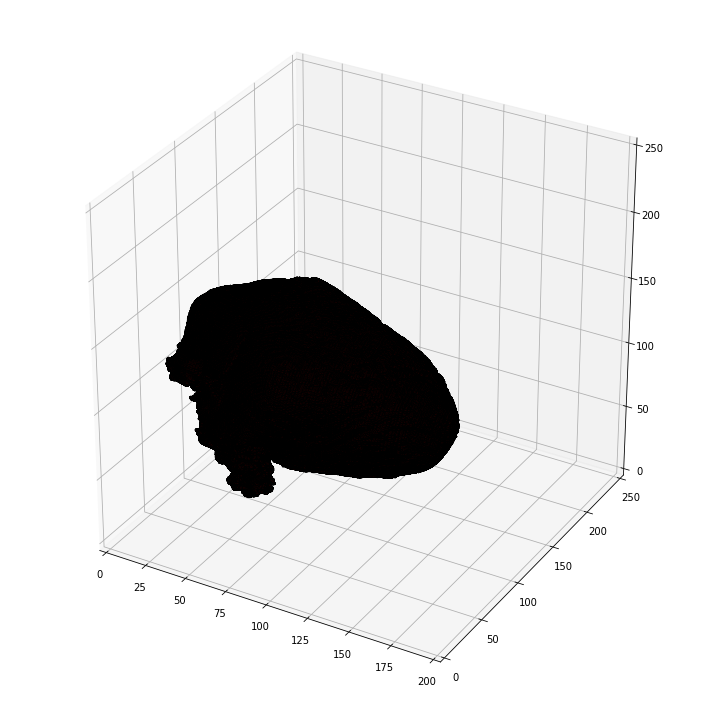

In [27]:
save_3d_model(PATH, val_names[1], dc_eval, classes=['background', 'Heart'], spacing=[0.5, 0.5, 0.5])

In [41]:
class MriEval():
    def __init__(self, learn, path):
        n_classes = learn.data.c
        self.learn = learn
        self.orig_data = learn.data
        
        self.path = path
        
        self.conf_mats = np.zeros((n_classes, n_classes))
        
    def one_study(self, study_name):
        ys = None
        data = mri_dataset_val(self.path, study_name, codes=["background", "Heart"])
        self.learn.data = data
        preds = self.learn.get_preds()
        xs = preds[0]
        ys = preds[1]
        return xs, ys[:,0]

def mri_dataset_val(path, val_study, codes):
    split_func = lambda x: x.stem.split('_')[0] == val_study
    get_y_fn = lambda x: path / 'mask' / x.name

    db = (SegmentationItemList.from_folder(path)
          .filter_by_func(lambda x: 'mask' not in str(x))
          .split_by_valid_func(split_func))
    
    db.valid.items = np.array(sorted(db.valid.items, key=lambda x: int(x.stem.split('_')[-1])))
    
    db = (db.label_from_func(get_y_fn, classes=codes)
          .transform(size=512, tfm_y=True)
          .databunch(bs=2,  no_check=True)
          .normalize(imagenet_stats))
    return db

In [42]:
mr_eval = MriEval(learn, PATH / 'test')

In [43]:
res, y = mr_eval.one_study('HH0315')

In [44]:
res.shape, y.shape

(torch.Size([120, 2, 512, 512]), torch.Size([120, 512, 512]))

In [45]:
#foo=np.array(res)[::-1,:,::-1,::-1]
foo=np.array(res)[::-1,...]
test=np.flipud(foo[80,1,:,:])
test.shape

(512, 512)

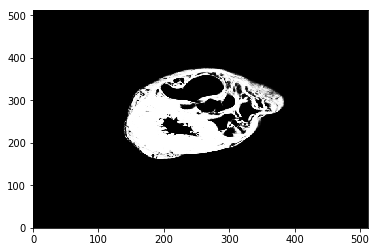

In [46]:
plt.set_cmap(plt.gray())
plt.pcolormesh(test)#np.flipud(foo[80,1, :, :]))

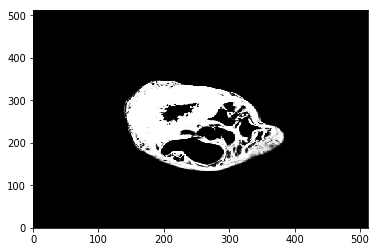

In [47]:
plt.set_cmap(plt.gray())
plt.pcolormesh(foo[80,1, :, :])

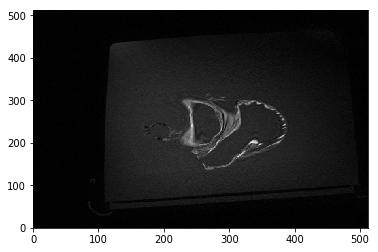

In [48]:
scan_slices = sorted([i for i in Path(PATH / 'HH0256' / 'Raw').ls()])
dc = dicom.read_file(str(scan_slices[13]))
ar = dc.pixel_array
plt.set_cmap(plt.gray())
plt.pcolormesh(ar)

In [49]:
def preds_to_dicom(preds, val_study):
    scan_slices = sorted([i for i in Path(PATH / val_study / 'Raw').ls()])
    preds = np.array(preds)[::-1,:,:,:]
    #preds = np.array(preds)[:,:,::-1,::-1]
    for ind, scan_path in enumerate(scan_slices):
        #print(str(scan_path)[-14:])
        dc = dicom.read_file(str(scan_path))
        px_arr = np.copy(dc.pixel_array)
        pred_ind = np.flipud(preds[ind, 1, ...])
        px_arr[pred_ind > 0.5] = 3000
        px_arr[pred_ind < 0.5] = 0
        dc.PixelData = px_arr.tostring()
        dc.save_as(str(Path(PATH / 'test' / 'final' / str(scan_path)[-14:])))
        print("completed frame {}".format(ind))

In [50]:
preds_to_dicom(res, 'HH0315')

completed frame 0
completed frame 1
completed frame 2
completed frame 3
completed frame 4
completed frame 5
completed frame 6
completed frame 7
completed frame 8
completed frame 9
completed frame 10
completed frame 11
completed frame 12
completed frame 13
completed frame 14
completed frame 15
completed frame 16
completed frame 17
completed frame 18
completed frame 19
completed frame 20
completed frame 21
completed frame 22
completed frame 23
completed frame 24
completed frame 25
completed frame 26
completed frame 27
completed frame 28
completed frame 29
completed frame 30
completed frame 31
completed frame 32
completed frame 33
completed frame 34
completed frame 35
completed frame 36
completed frame 37
completed frame 38
completed frame 39
completed frame 40
completed frame 41
completed frame 42
completed frame 43
completed frame 44
completed frame 45
completed frame 46
completed frame 47
completed frame 48
completed frame 49
completed frame 50
completed frame 51
completed frame 52
com

In [53]:
def view_final(val_study, ind):
    scan_slices = sorted([i for i in Path(PATH / 'test' / 'final').ls() if val_study in i.name])
    scan = dicom.read_file(str(scan_slices[ind]))
    return scan
    

In [58]:
scan = view_final('HH315', 80)

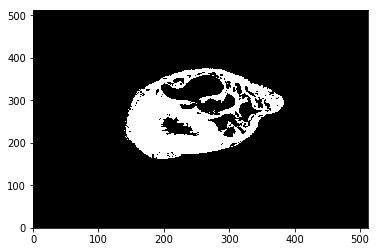

In [59]:
ar = scan.pixel_array
plt.set_cmap(plt.gray())
plt.pcolormesh(ar)